## Loading and Preparing Data 

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy 
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Trainng Samples loaded from Github Repo
ratings_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/ratings.dat'
titles_path = 'https://raw.githubusercontent.com/usef-kh/EC503Project/master/Datasets/ml-1m/movies.dat'

ratings = pd.read_csv(ratings_path, sep  = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
titles = pd.read_csv(titles_path, sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding ='latin-1')
data = pd.merge(ratings, titles, on='MovieID')

ntotal = data.shape[0]
ntrain = int(np.floor(ntotal*0.85))
ntest = ntotal - ntrain

print(f"ntotal: {ntotal}\nntrain: {ntrain}\nntest: {ntest}")

data.head()

ntotal: 1000209
ntrain: 850177
ntest: 150032


,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


### Suffling dataset and splitting into test, train, and valiation

In [79]:
np.random.seed(42)
shuffled_data = data.reindex(np.random.permutation(data.index))

train = deepcopy(shuffled_data)
test = deepcopy(shuffled_data)

train['Rating'][ntrain:] = -1
test['Rating'][:ntrain] = -1

train_mtx = train.pivot_table(index='UserID', columns='Title', values='Rating')
test_mtx = test.pivot_table(index='UserID', columns='Title', values='Rating')

train_mtx = train_mtx.values
test_mtx = test_mtx.values


train_mtx[train_mtx == -1] = np.nan
test_mtx[test_mtx == -1] = np.nan

train_select = ~(np.isnan(train_mtx))
test_select = ~(np.isnan(test_mtx))

user_means = np.nanmean(train_mtx, axis = 0)
movie_means = np.nanmean(train_mtx, axis = 1)

print(np.shape(test_mtx), np.shape(train_mtx))
print(np.shape(test_select), np.shape(train_select))

train.head()

(6040, 3706) (6040, 3706)
(6040, 3706) (6040, 3706)


,UserID,MovieID,Rating,Timestamp,Title,Genres
895536,5755,184,3,958280246,Nadja (1994),Drama
899739,4585,519,3,964321944,Robocop 3 (1993),Sci-Fi|Thriller
55687,1503,3114,4,974762175,Toy Story 2 (1999),Animation|Children's|Comedy
63727,2166,648,4,974614593,Mission: Impossible (1996),Action|Adventure|Mystery
822011,3201,2178,5,968626301,Frenzy (1972),Thriller


In [80]:
um = np.nanmean(user_means, axis = 0)
mm = np.nanmean(movie_means, axis = 0)

unan = np.argwhere(np.isnan(user_means))
mnan = np.argwhere(np.isnan(movie_means))

movie_means[mnan] = mm
user_means[unan] = um


print(user_means)
print(movie_means)


[3.03030303 3.35       2.75       ... 3.2407125  2.57142857 3.24928367]
[4.17021277 3.7027027  3.91111111 ... 3.5625     3.87378641 3.5970696 ]


In [0]:
[m,u] = train_mtx.shape

for i in range(m):
  for j in range(u):
    if(np.isnan(train_mtx[i,j])):
      train_mtx[i,j] = (user_means[j] + movie_means[i])/2
 

In [84]:
train_mtx

array([[3.6002579 , 3.76010638, 3.46010638, ..., 3.70546263, 3.37082067,
        3.70974822],
       [3.36650287, 3.52635135, 3.22635135, ..., 3.4717076 , 3.13706564,
        3.47599319],
       [3.47070707, 3.63055556, 3.33055556, ..., 3.5759118 , 3.24126984,
        3.58019739],
       ...,
       [3.29640152, 3.45625   , 3.15625   , ..., 3.40160625, 3.06696429,
        3.40589183],
       [3.45204472, 3.6118932 , 3.3118932 , ..., 3.55724945, 3.22260749,
        3.56153504],
       [3.31368631, 3.4735348 , 3.1735348 , ..., 3.41889105, 3.08424908,
        3.42317663]])

#### Obtaining MAE on test set after filling movie means only to compare with performance of SVD 

In [85]:
from sklearn.metrics import mean_absolute_error as mae

result = train_mtx[test_select].flatten()
ground_truth = test_mtx[test_select].flatten()

print("MAE by only filling mean value:")
print(mae(result,ground_truth))

MAE by only filling mean value:
0.7712933153690582


## Implementing Matrix Factorization using SVD

### Tuning hyperparameters using hold out validation
#### SVD essentially performs dimention reduction through selecting the rank of the resultant matricies, specifically Sigma.

#### On a high level of understanding:
#### - U corresponds to the users' features
#### - V' captures movies' features. 

#### Obviously, the higher the rank, the more information is perserved during the reduction. However, the larger its value, the less we are learning the actual data and the more we are overfitting the training set. For this, we will be corss validating our results and minimizing the mse over a validation set to tune the value of k.

In [0]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error as mae

tmax = 21
MAE = []
reconstruction = deepcopy(train_mtx)
for t in range(tmax):
  U, sigma, Vt = svds(reconstruction, 50)
  sigma = np.diag(sigma)

  reconstruction = np.round(2*(np.dot(np.dot(U, sigma), Vt)))/2
  reconstruction[train_select] = train_mtx[train_select]

  reconstruction[reconstruction > 5] = 5
  reconstruction[reconstruction < 0.5] = 0.5
  
  result = reconstruction[test_select].flatten() 
  ground_truth = test_mtx[test_select].flatten()

  MAE.append(mae(result,ground_truth))

Minimum MAE: 0.70
Maximum MAE: 0.71


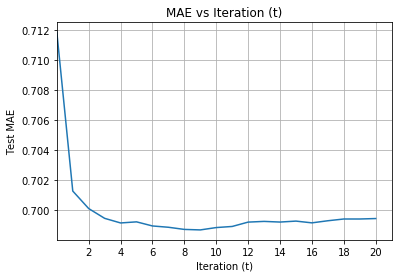

In [87]:
plt.plot(list(range(tmax)), MAE)
plt.xlabel('Iteration (t)')
plt.ylabel('Test MAE')
plt.xticks(np.arange(2, tmax, 2))
plt.xlim(0,tmax)
plt.title("MAE vs Iteration (t)")
plt.grid()

print("Minimum MAE:", "{0:0.2f}".format(min(MAE)))
print("Maximum MAE:", "{0:0.2f}".format(max(MAE)))